OK: Loaded grape.py from c:\Users\awwal\OneDrive\Desktop\GRAPE_PI _GROW\grape\grape.py
OK: PI_Grow available
OK: functions.py loaded
OK: DEAP ready
 30 runs x 200 gens x 200 pop | Methods: Random, Sensible, PI Grow

STARTING: 4x3x30 = 360 runs


##################################################
# Keijzer-6: Harmonic (1D)
##################################################
  Grammar: 2 NTs, 20 productions
  Random run 1/30...
  Random run 5/30...
  Random run 10/30...
  Random run 15/30...
  Random run 20/30...
  Random run 25/30...
  Random run 30/30...
  Random: 927s (30.9s/run)
  Sensible run 1/30...
  Sensible run 5/30...
  Sensible run 10/30...
  Sensible run 15/30...
  Sensible run 20/30...
  Sensible run 25/30...
  Sensible run 30/30...
  Sensible: 1240s (41.3s/run)
  PI Grow run 1/30...
  PI Grow run 5/30...
  PI Grow run 10/30...
  PI Grow run 15/30...
  PI Grow run 20/30...
  PI Grow run 25/30...
  PI Grow run 30/30...
  PI Grow: 1584s (52.8s/run)

############################

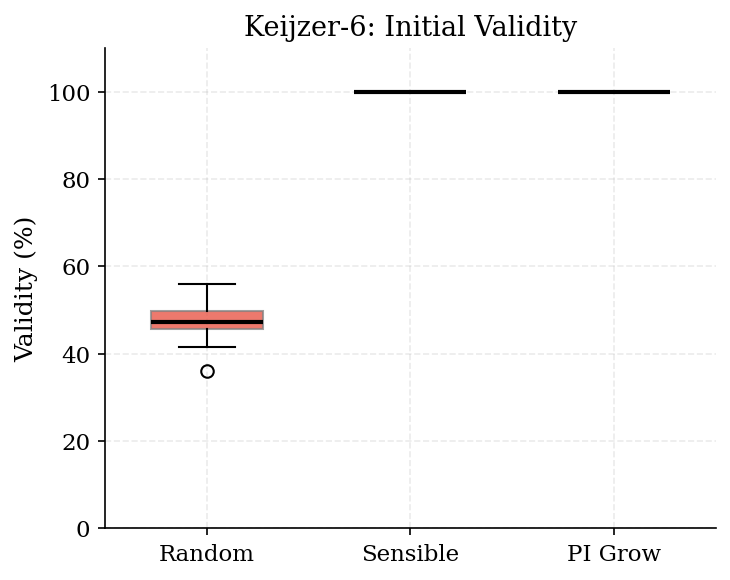

  Saved: fig1_keijzer6_validity.png


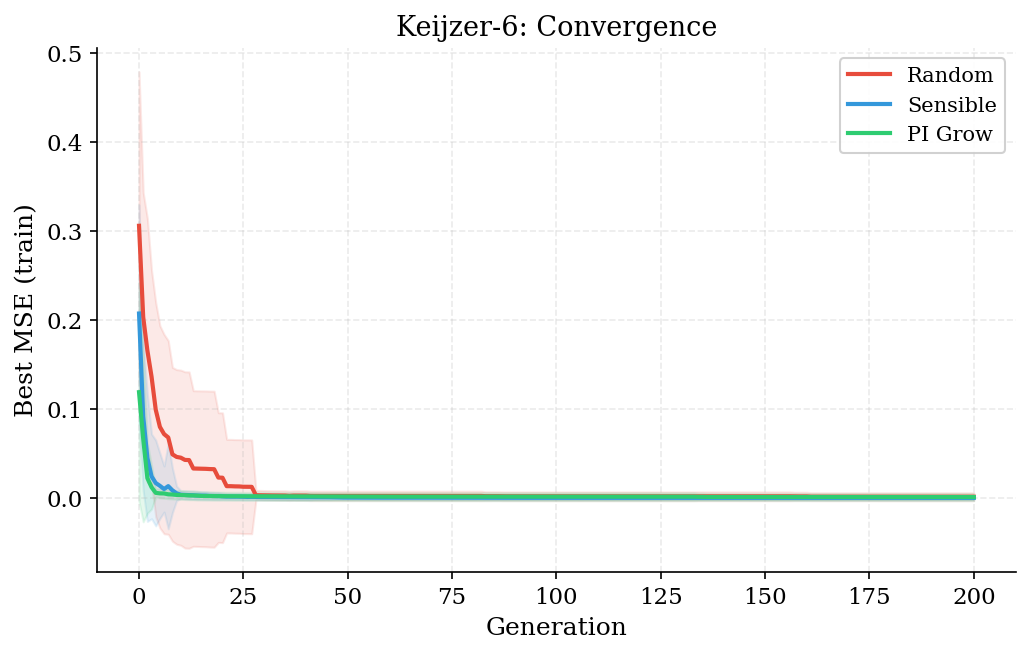

  Saved: fig2_conv_keijzer6.png


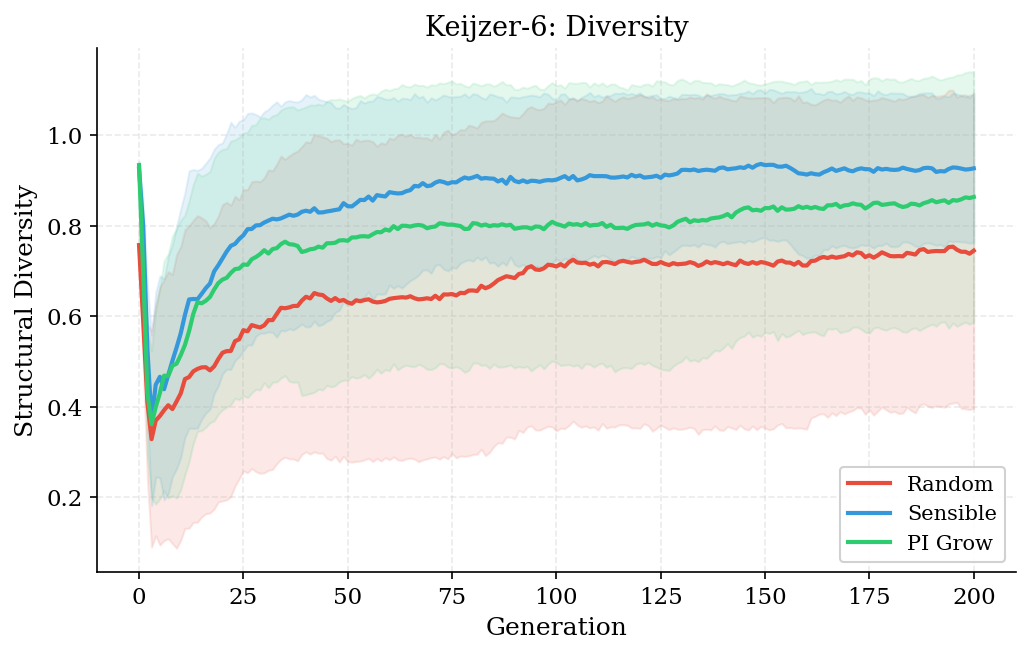

  Saved: fig3_div_keijzer6.png


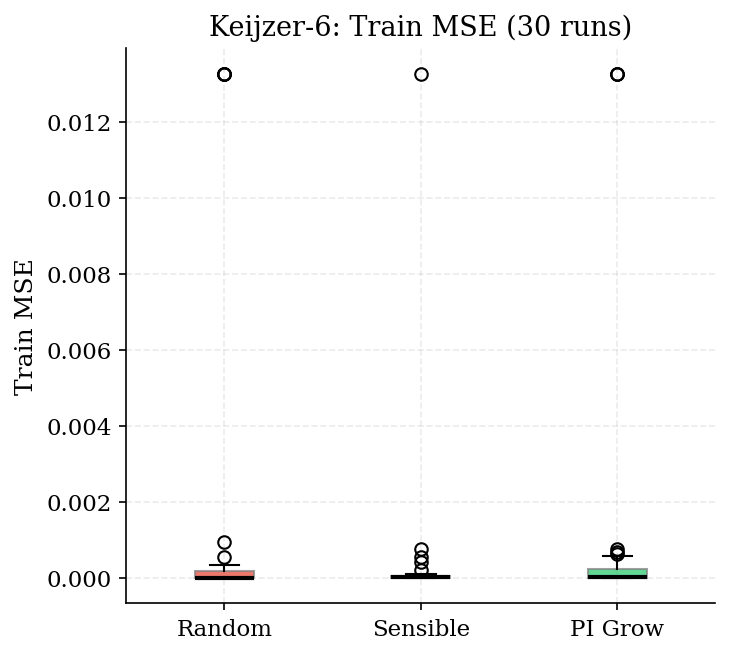

  Saved: fig4_train_keijzer6.png


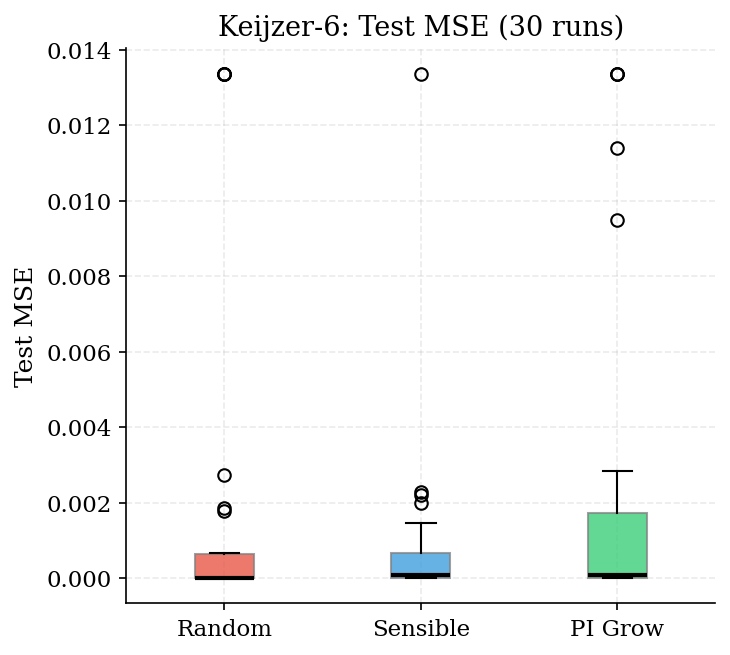

  Saved: fig5_test_keijzer6.png


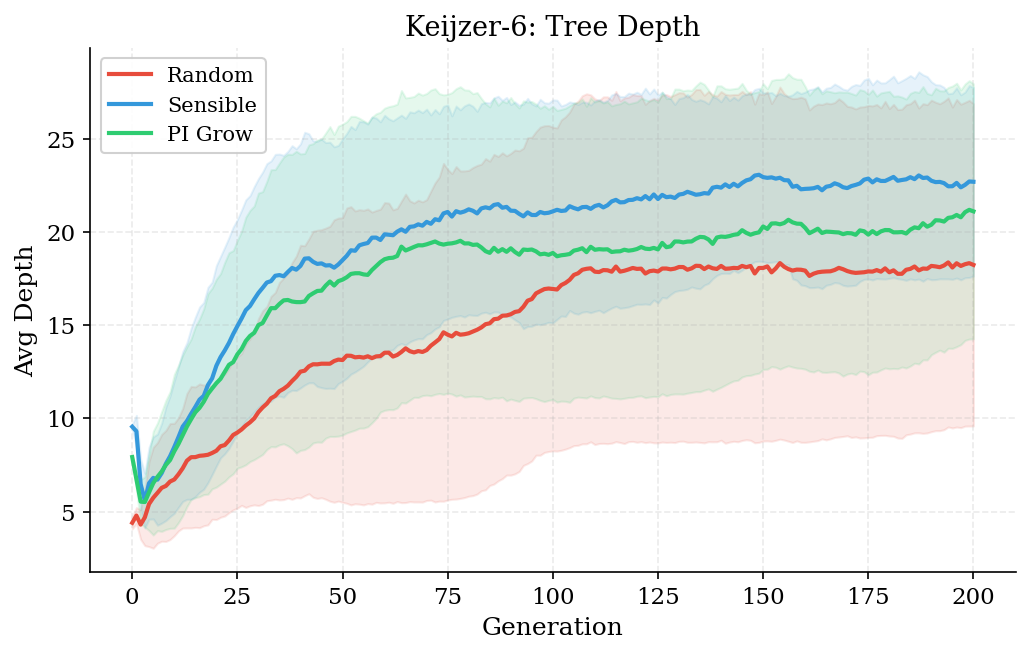

  Saved: fig6_depth_keijzer6.png


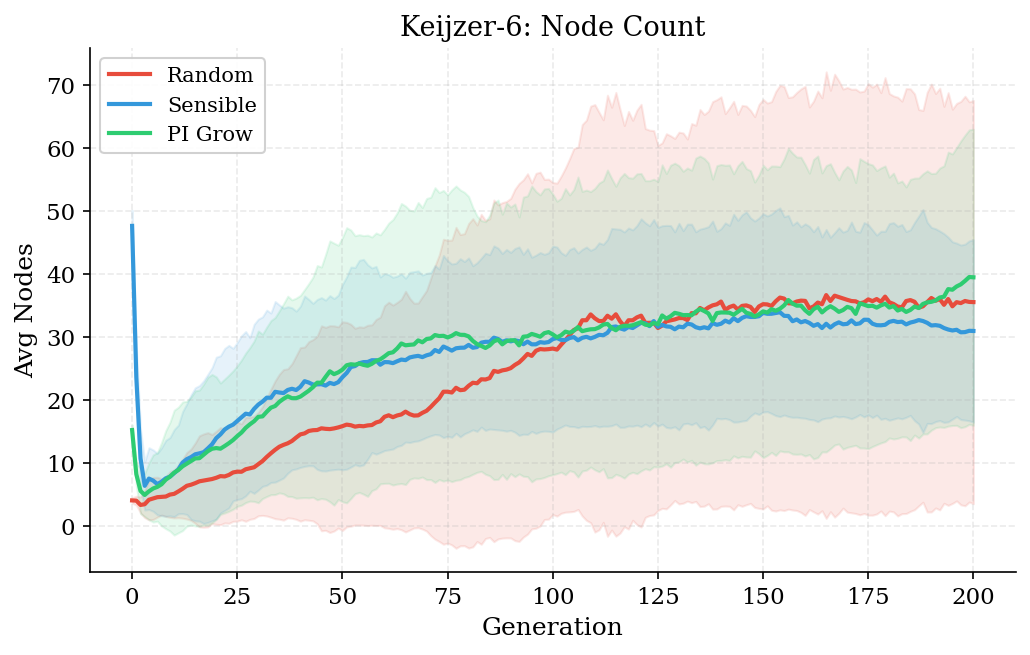

  Saved: fig7_nodes_keijzer6.png


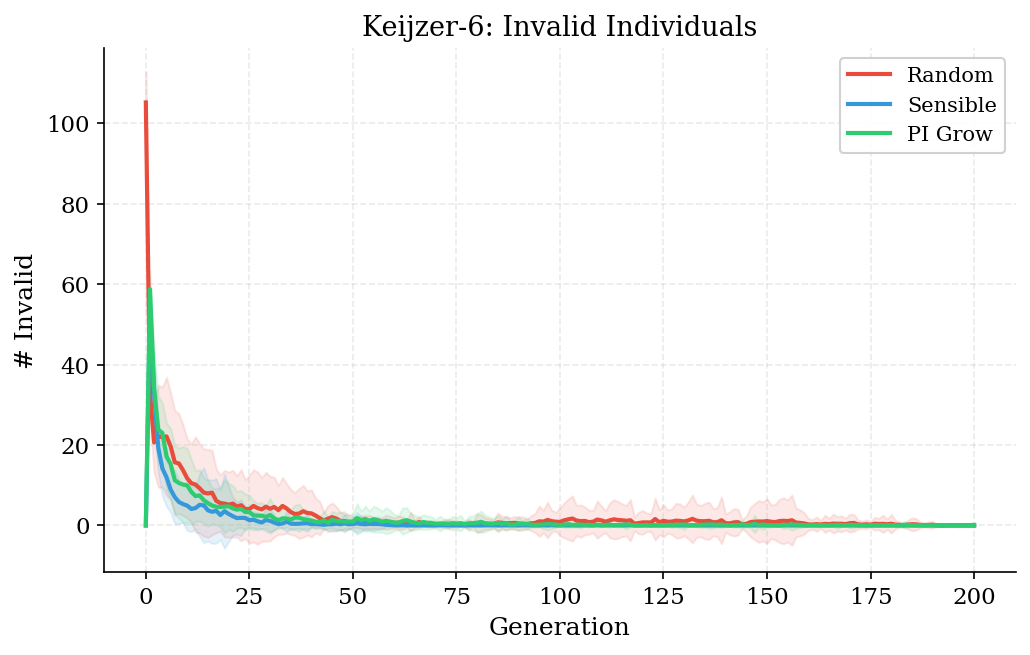

  Saved: fig8_inv_keijzer6.png


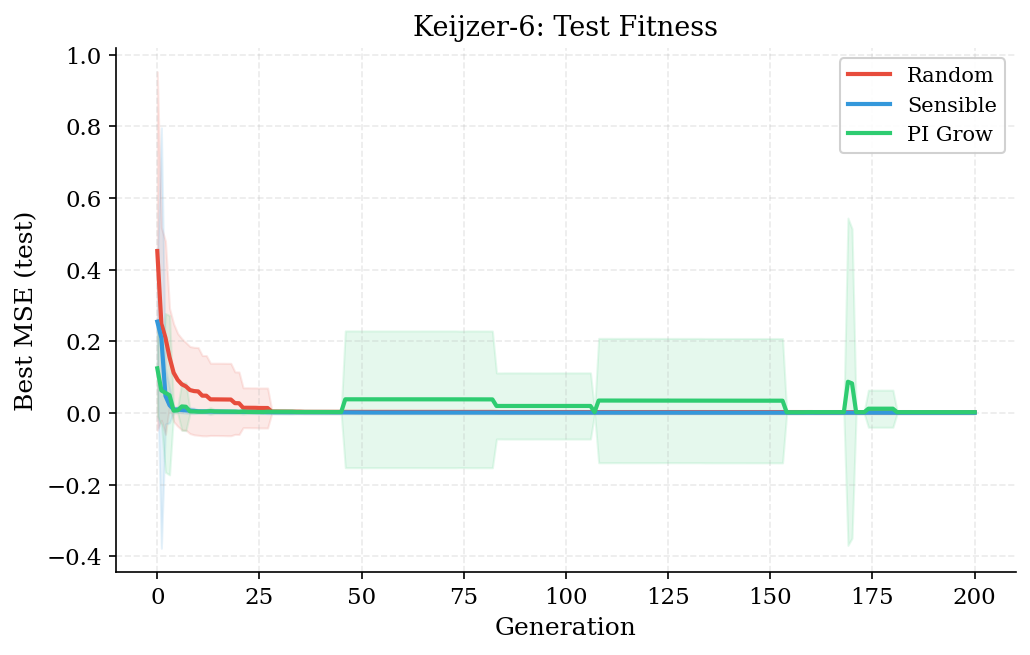

  Saved: fig9_testconv_keijzer6.png

--- Nguyen-7 ---


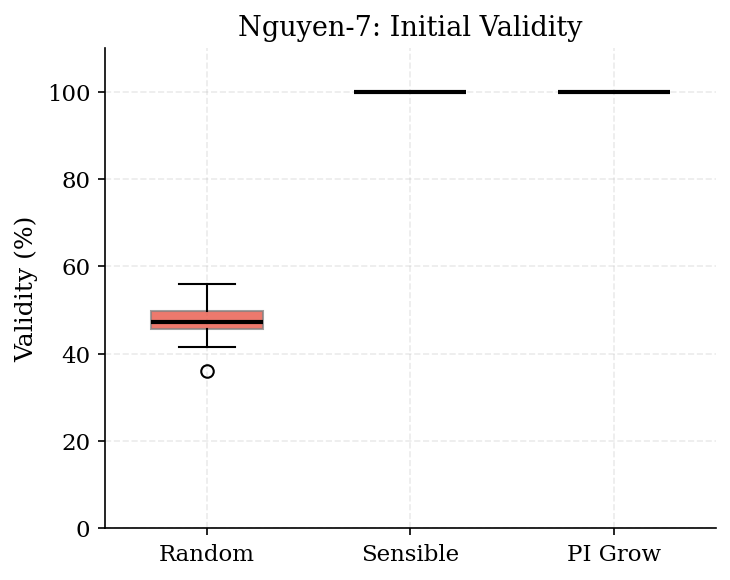

  Saved: fig1_nguyen7_validity.png


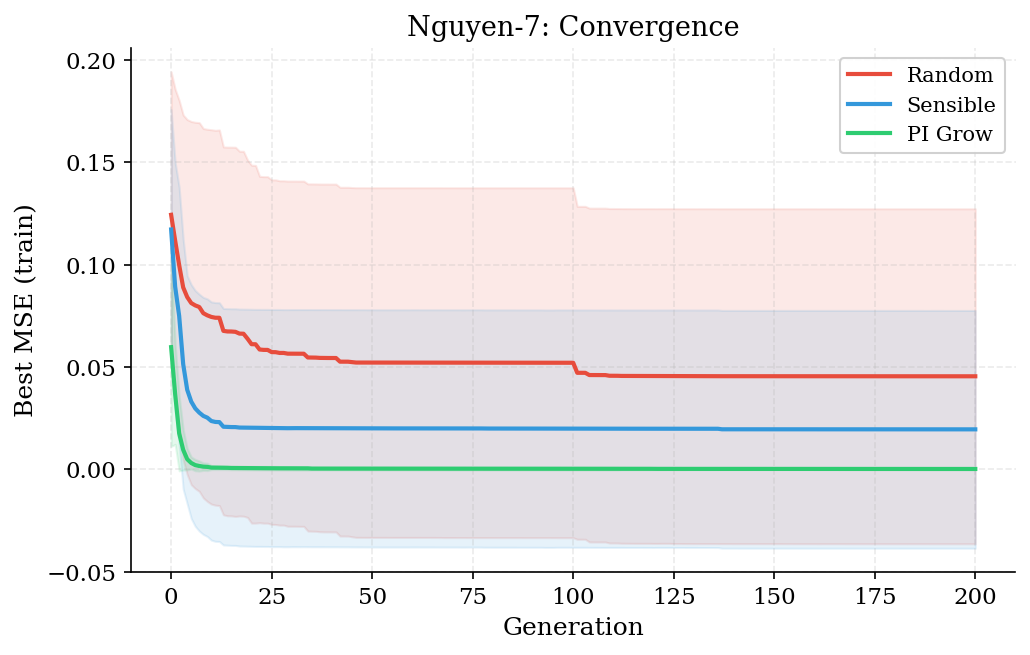

  Saved: fig2_conv_nguyen7.png


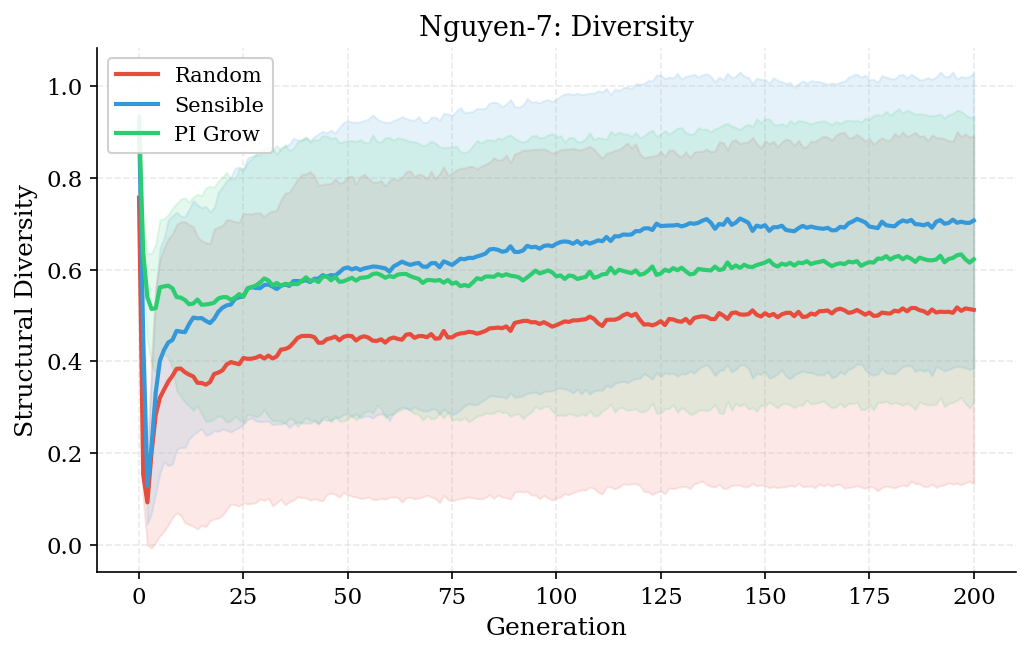

  Saved: fig3_div_nguyen7.png


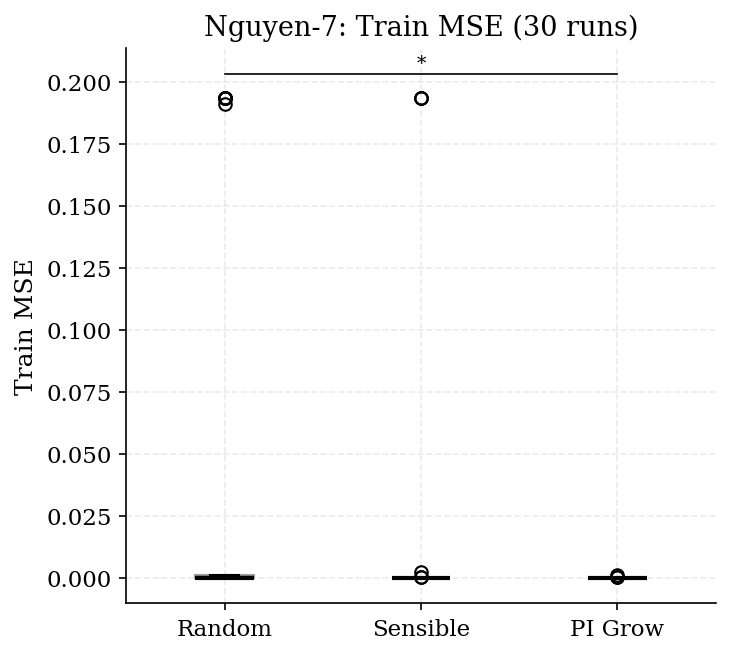

  Saved: fig4_train_nguyen7.png


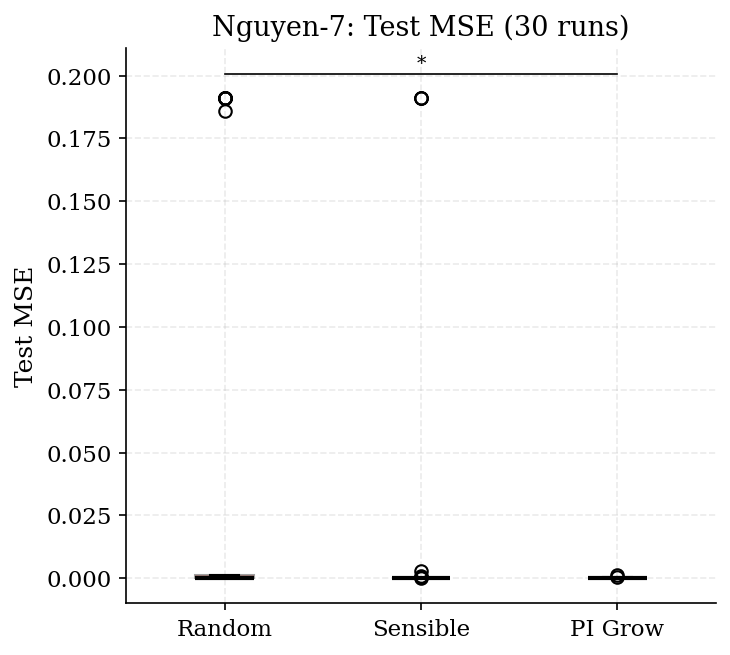

  Saved: fig5_test_nguyen7.png


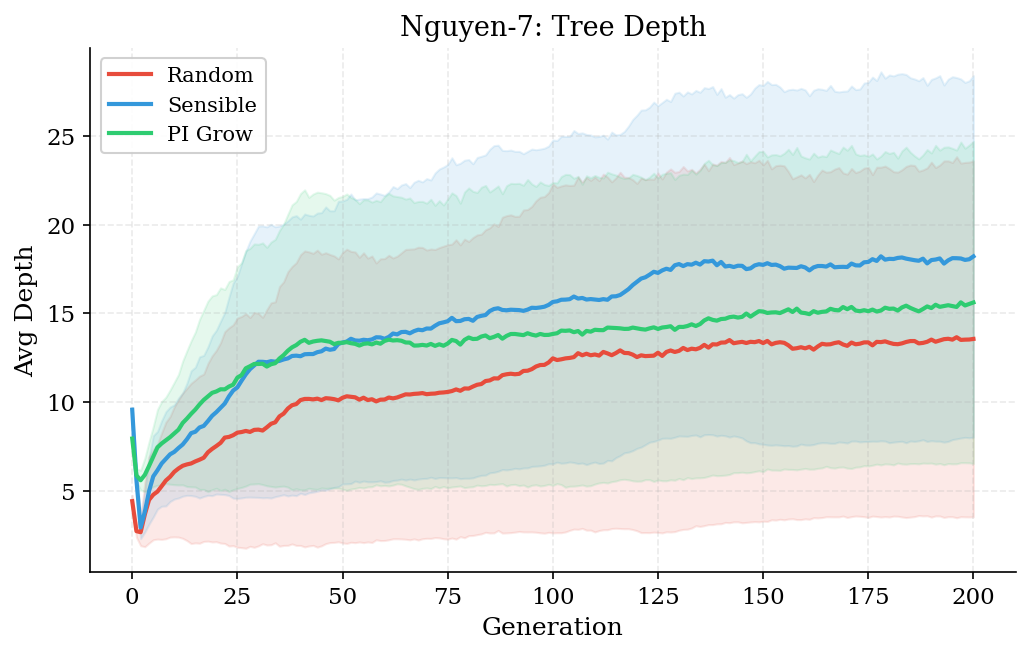

  Saved: fig6_depth_nguyen7.png


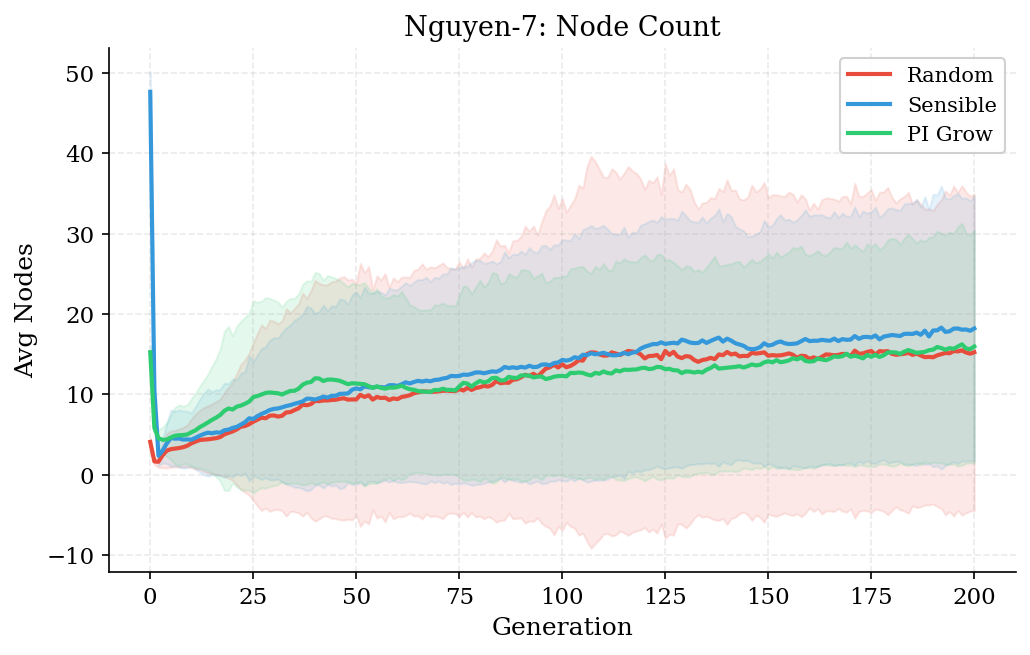

  Saved: fig7_nodes_nguyen7.png


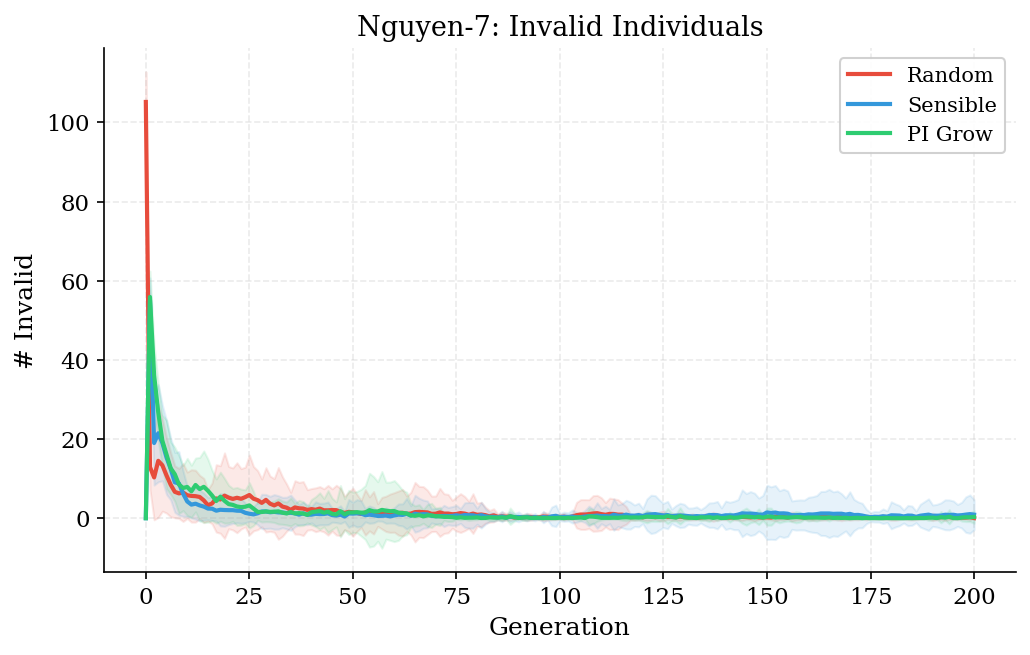

  Saved: fig8_inv_nguyen7.png


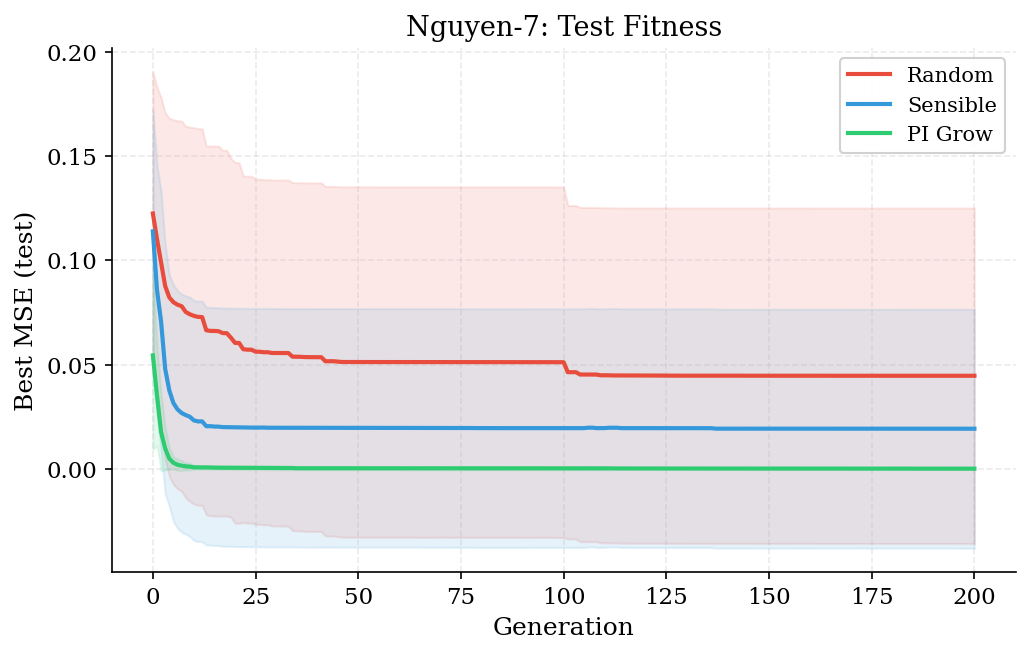

  Saved: fig9_testconv_nguyen7.png

--- Pagie-1 ---


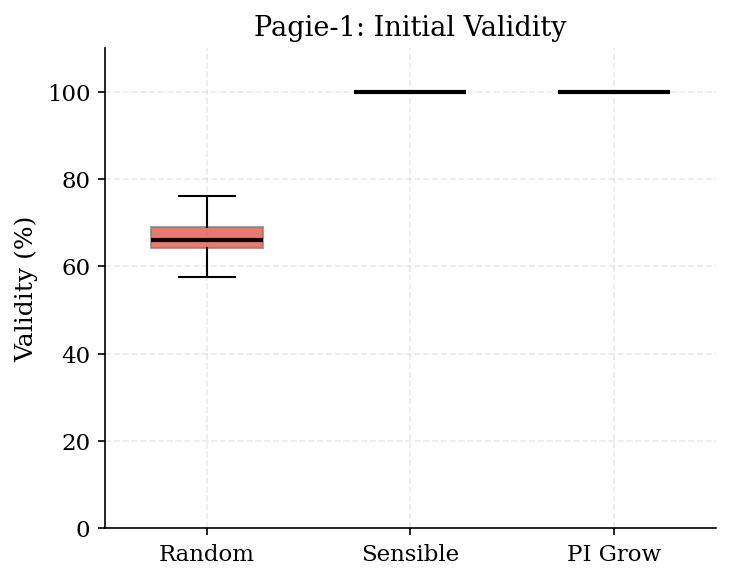

  Saved: fig1_pagie1_validity.png


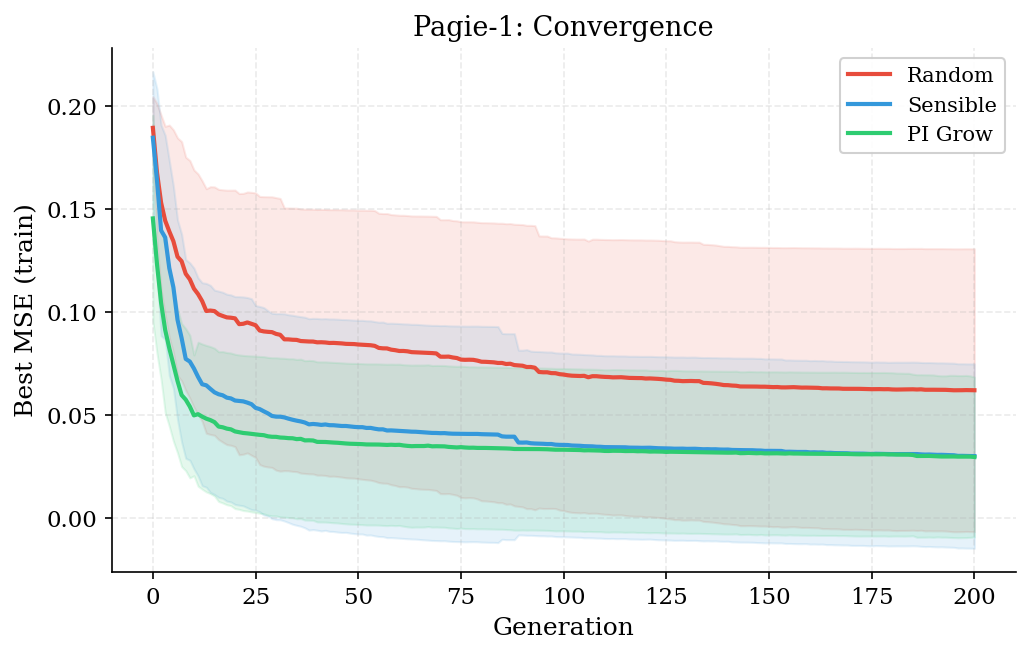

  Saved: fig2_conv_pagie1.png


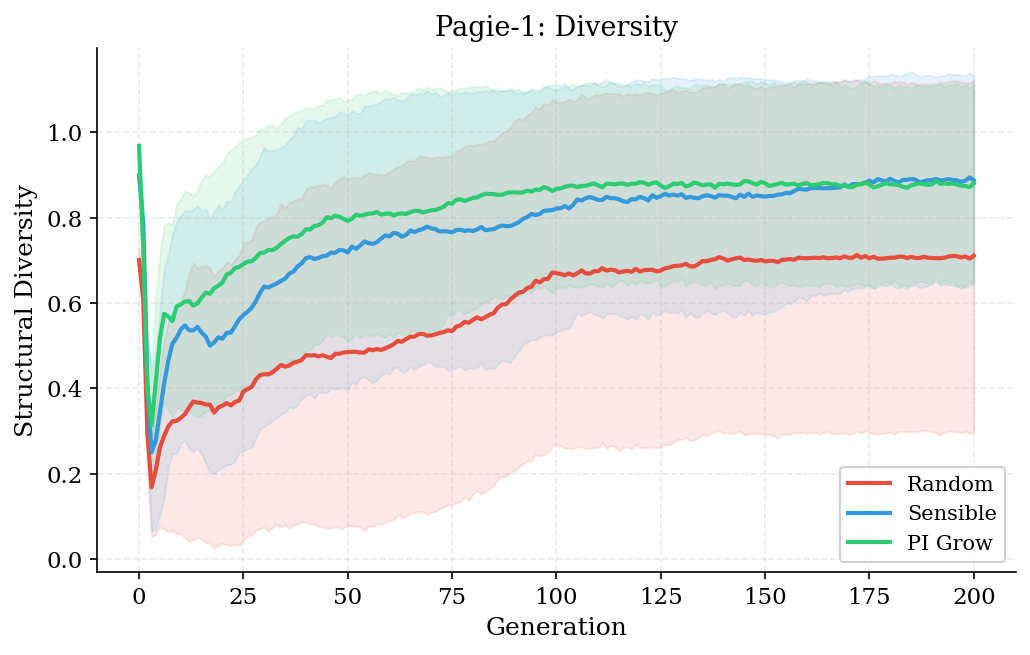

  Saved: fig3_div_pagie1.png


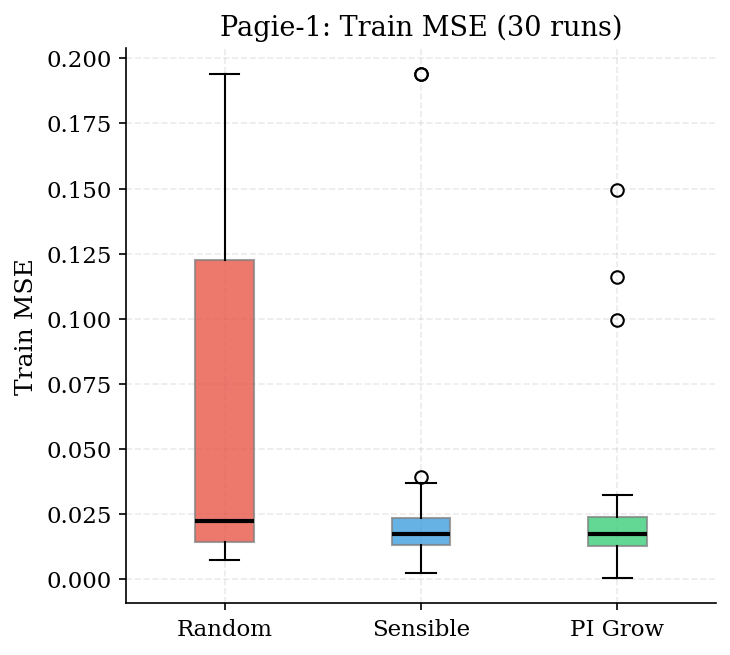

  Saved: fig4_train_pagie1.png


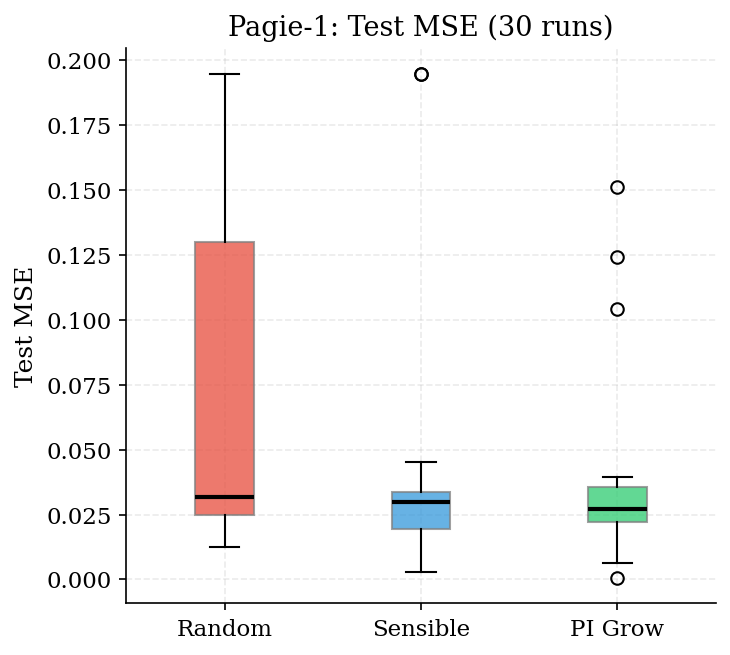

  Saved: fig5_test_pagie1.png


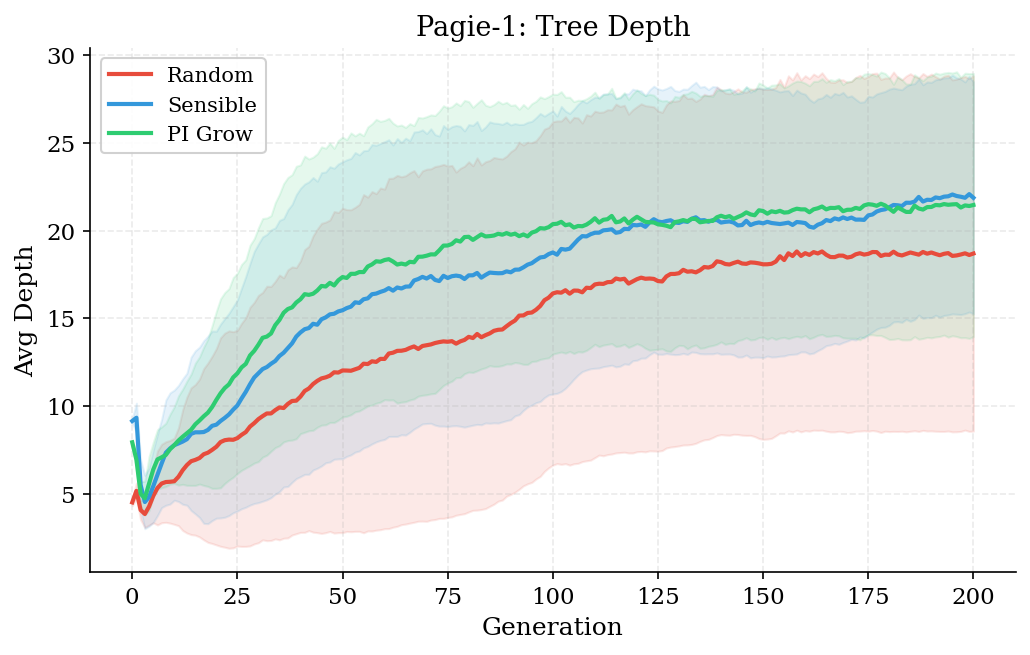

  Saved: fig6_depth_pagie1.png


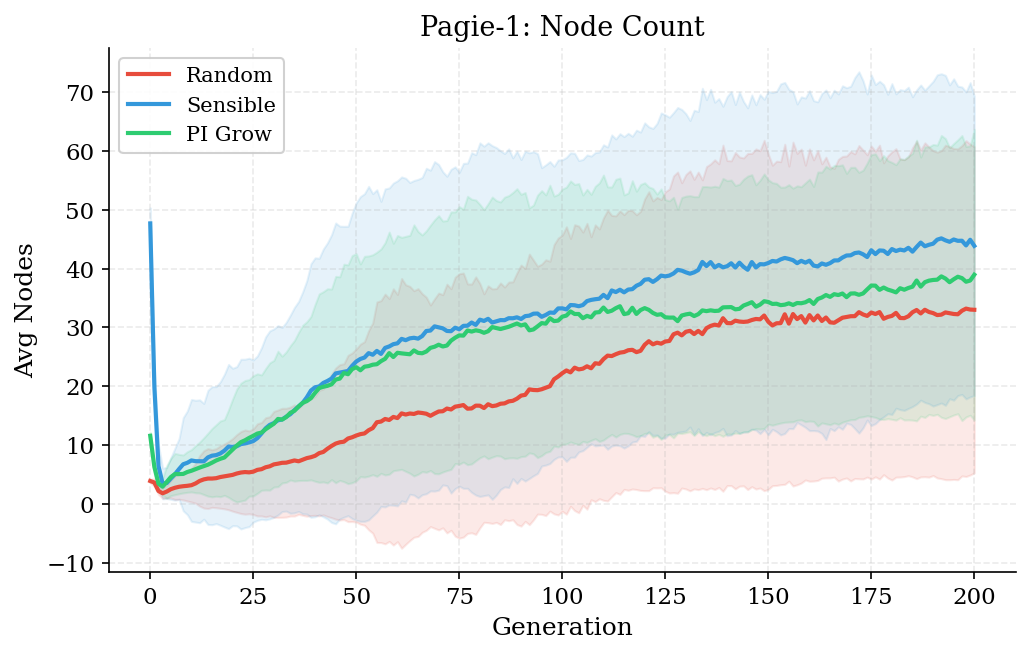

  Saved: fig7_nodes_pagie1.png


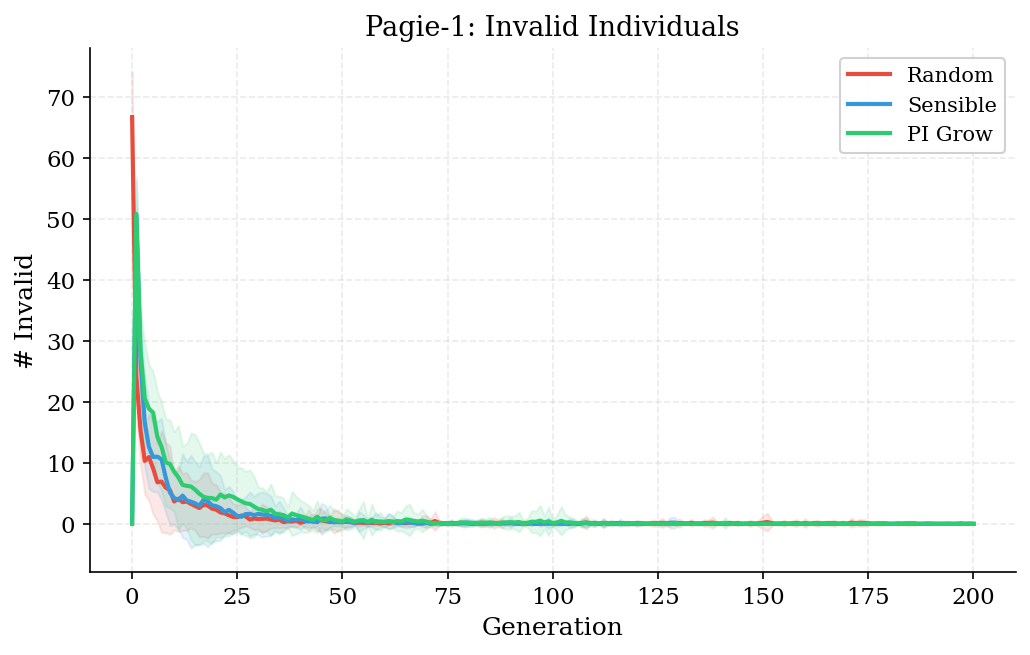

  Saved: fig8_inv_pagie1.png


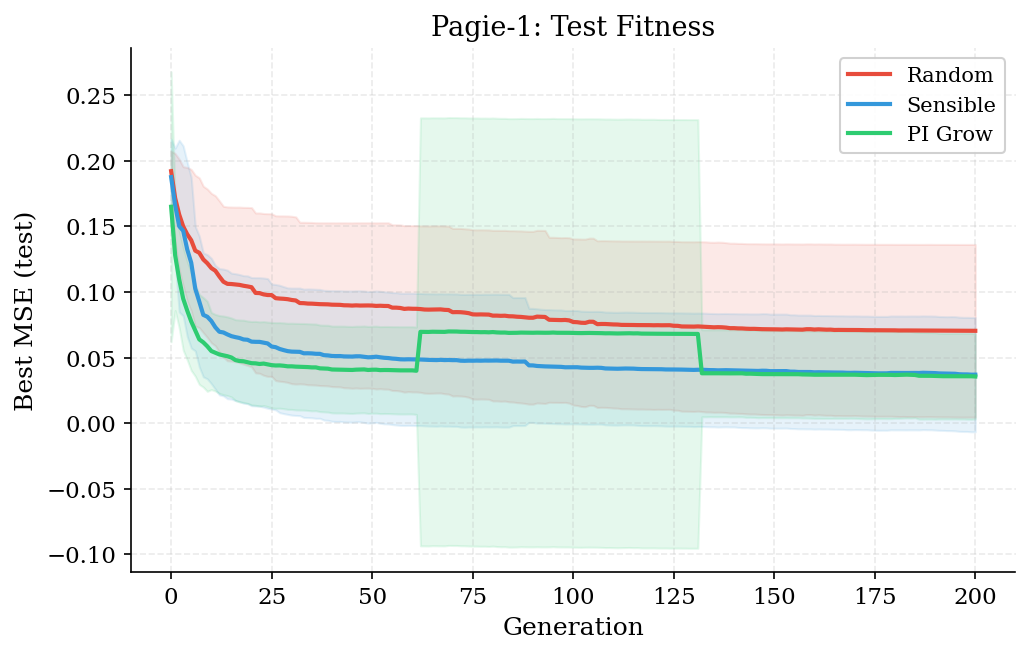

  Saved: fig9_testconv_pagie1.png

--- Diabetes ---


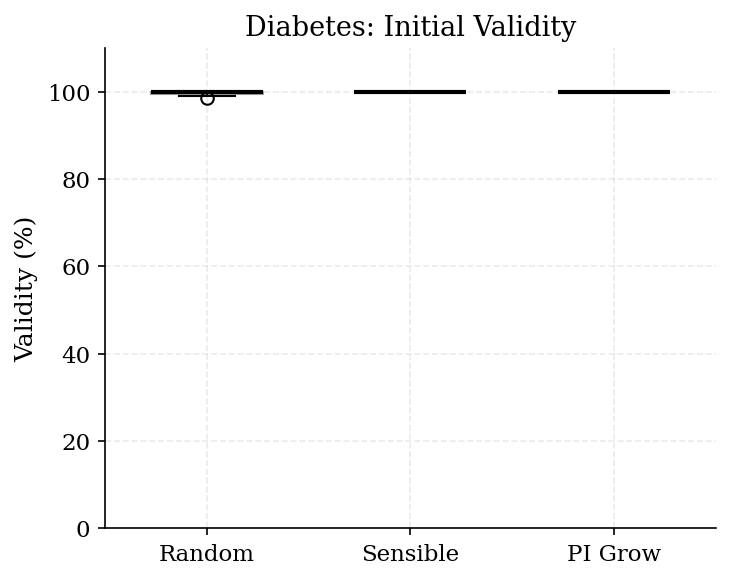

  Saved: fig1_diabetes_validity.png


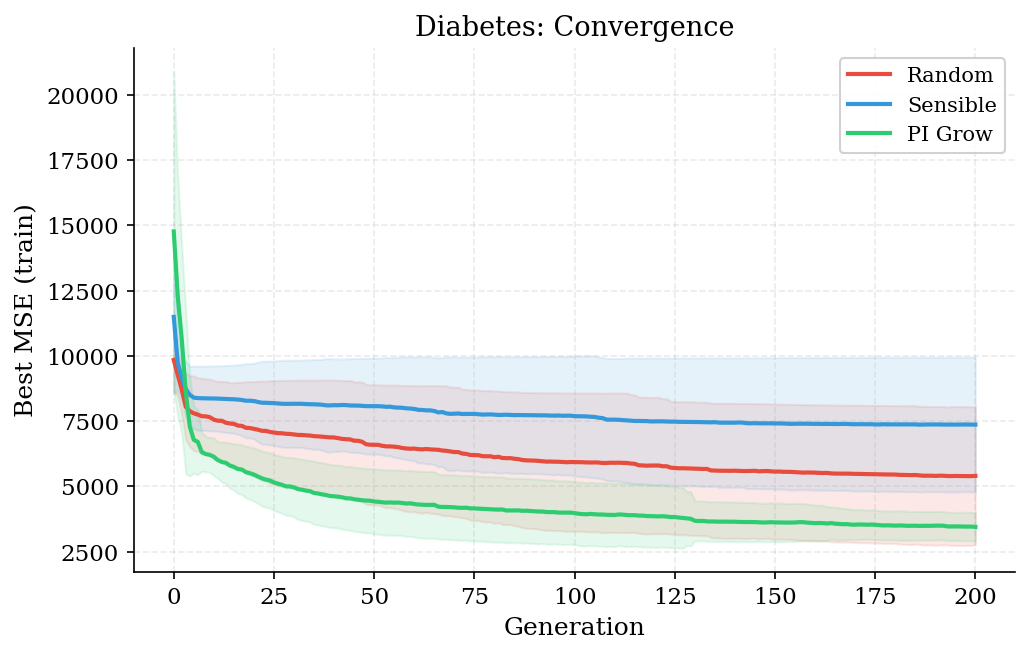

  Saved: fig2_conv_diabetes.png


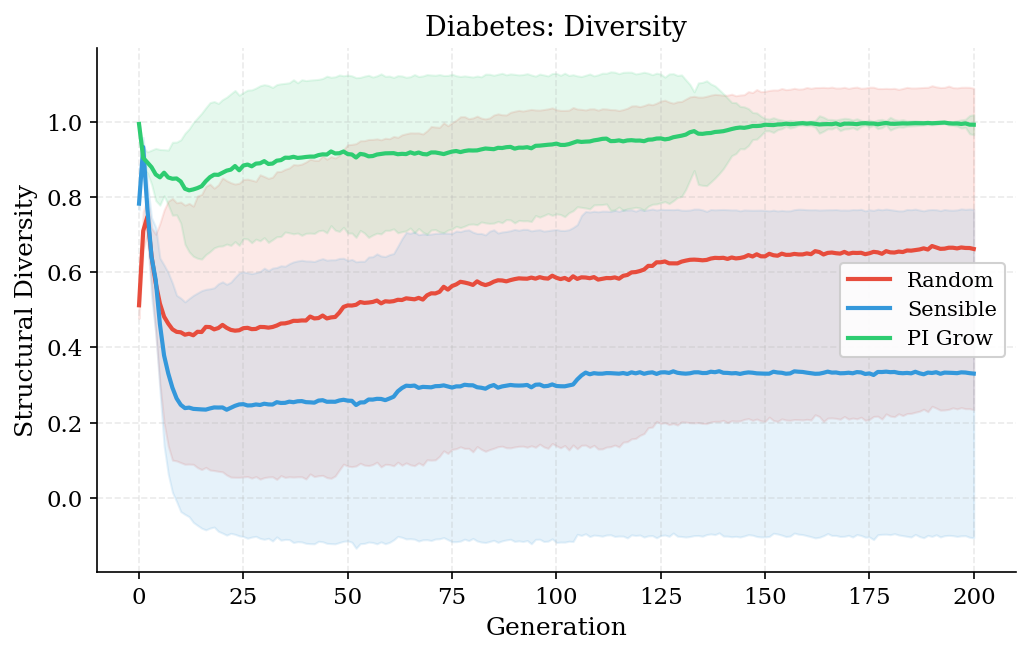

  Saved: fig3_div_diabetes.png


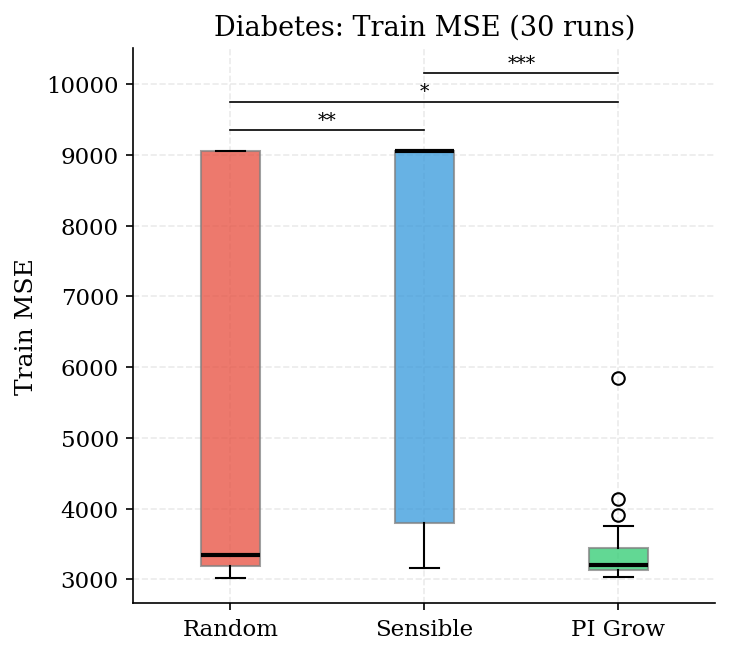

  Saved: fig4_train_diabetes.png


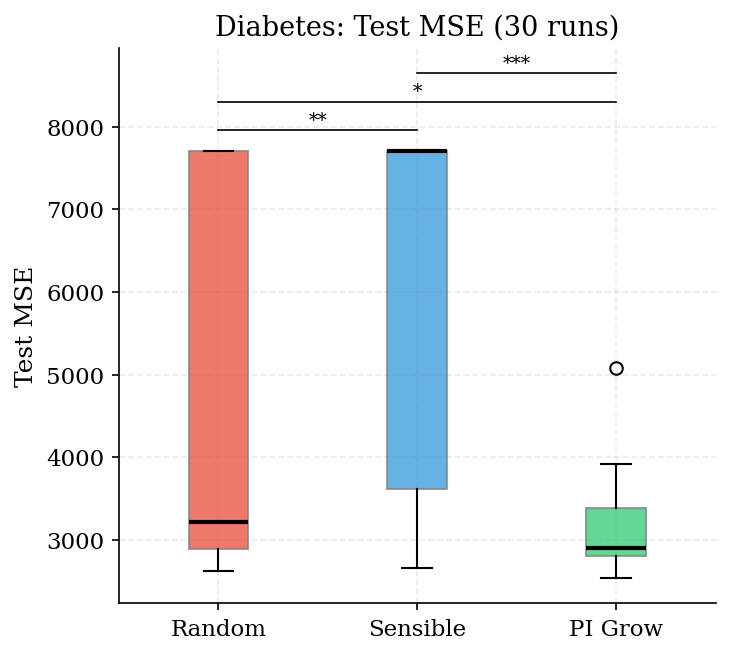

  Saved: fig5_test_diabetes.png


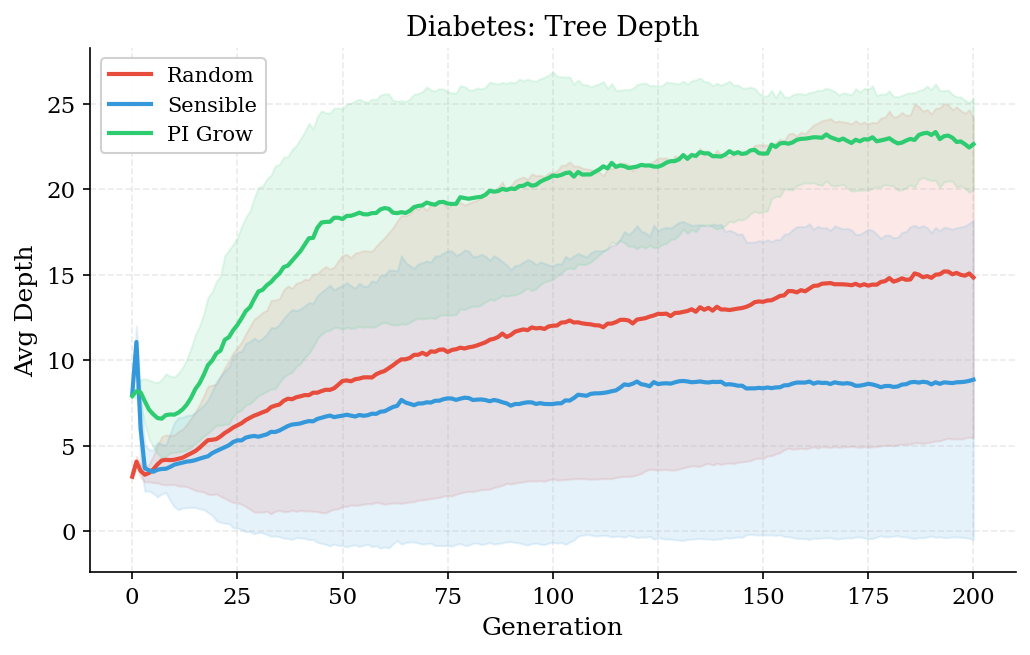

  Saved: fig6_depth_diabetes.png


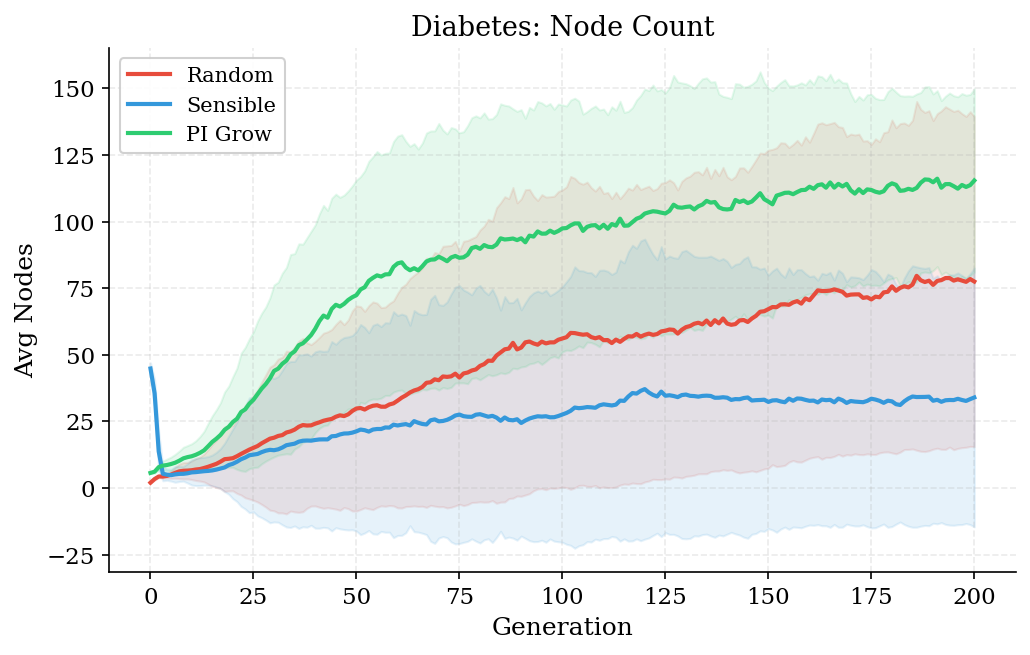

  Saved: fig7_nodes_diabetes.png


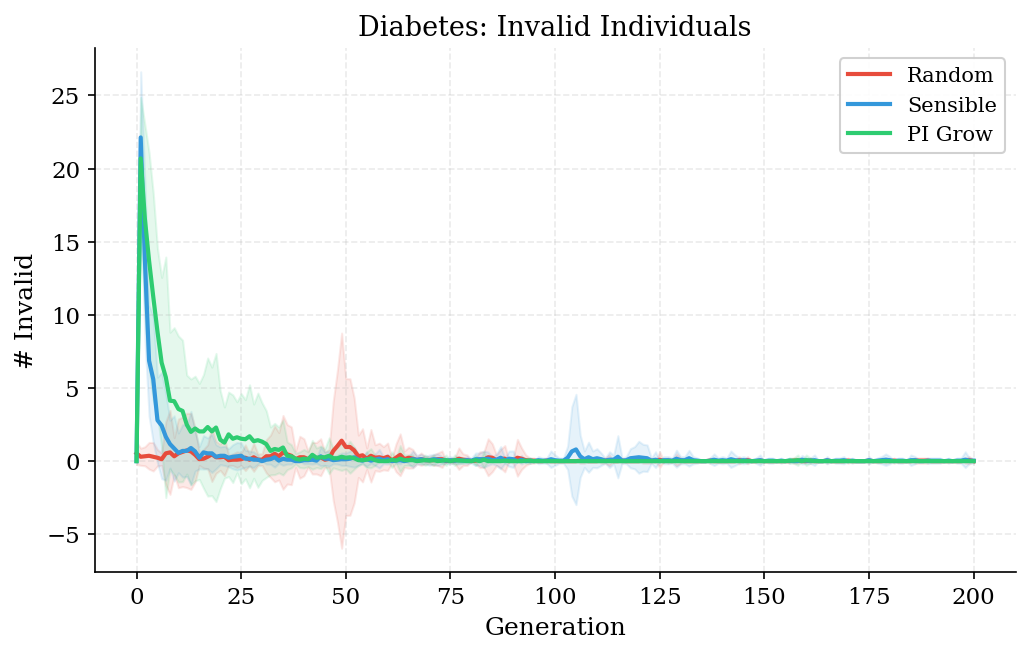

  Saved: fig8_inv_diabetes.png


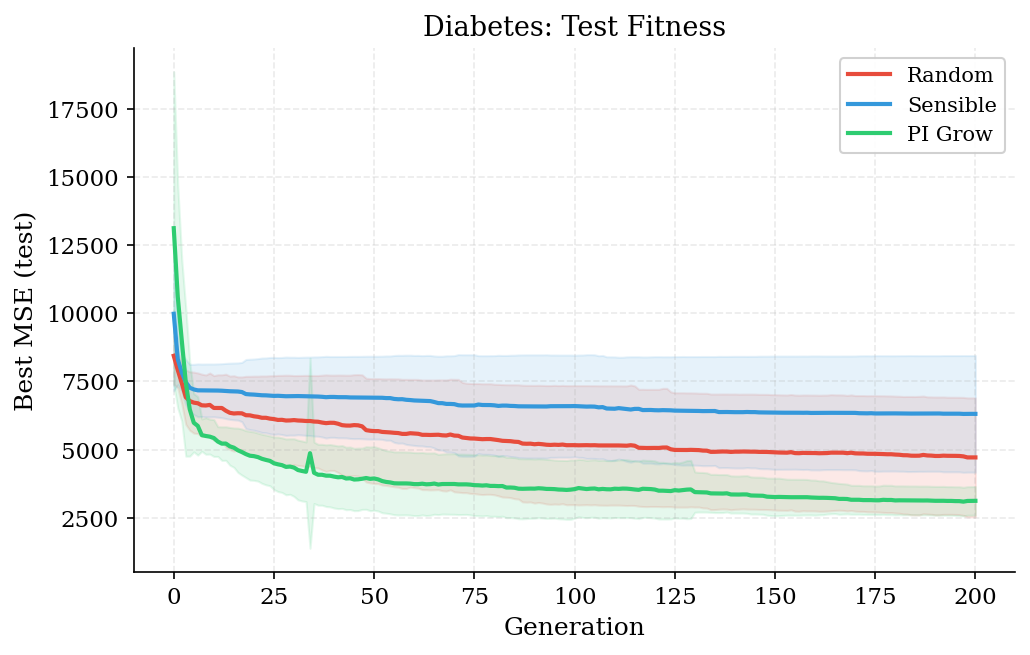

  Saved: fig9_testconv_diabetes.png


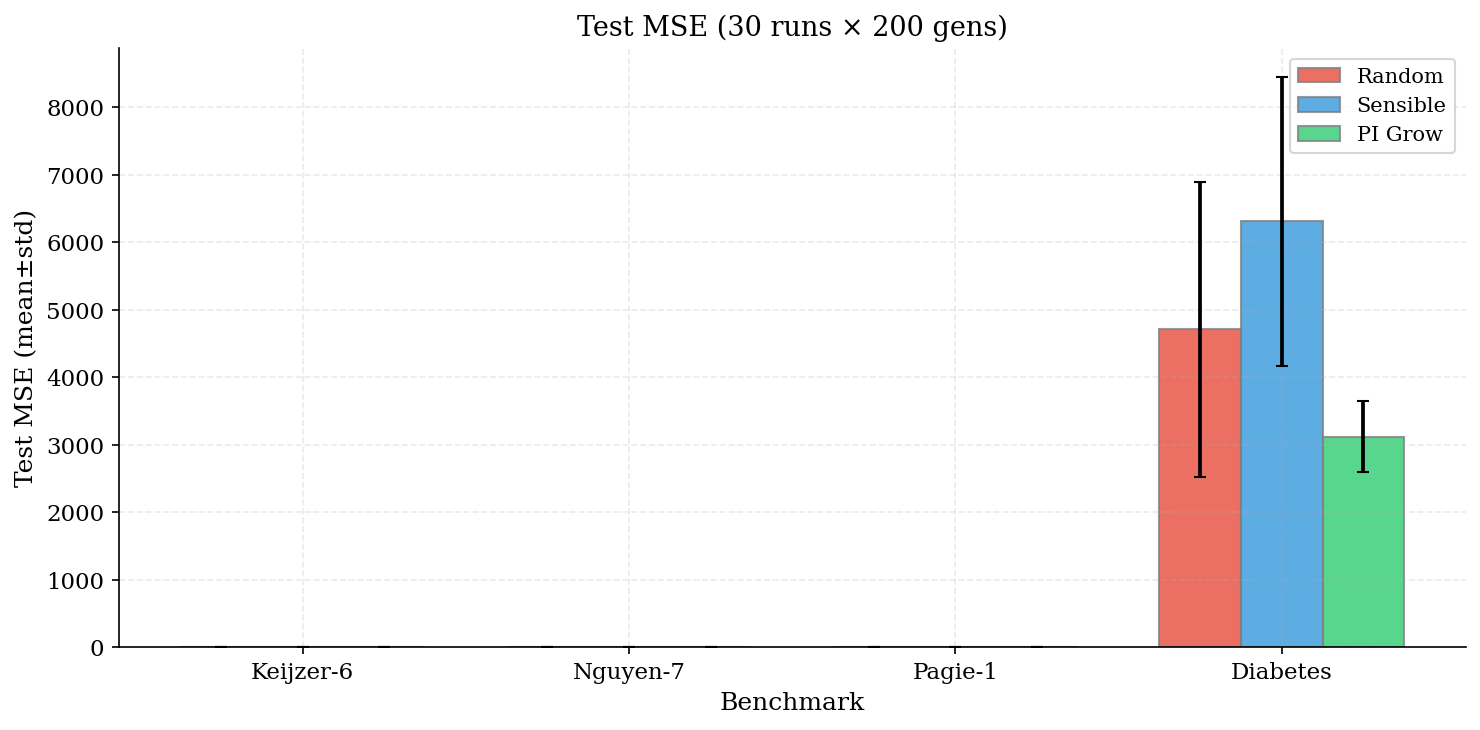

Saved: fig10_summary.png

 DONE — 194.4 min
 Files: fig1-10*.png, ge_results_raw.json, experiment_config.json


In [2]:
#!/usr/bin/env python3
# ===========================================================================
#
#  GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON
#  3 Methods: Random, Sensible (RHH), PI Grow
#  4 Benchmarks: Keijzer-6, Nguyen-7, Pagie-1, Diabetes
# ===========================================================================

import sys, os, importlib.util, numpy as np, random, copy, tempfile
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import mannwhitneyu
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import warnings, time, json
from datetime import datetime
warnings.filterwarnings('ignore')

# ── Force-load LOCAL grape.py (bypasses pip version) ─────────────────
_DIR = os.getcwd()
_LOCAL = os.path.join(_DIR, 'grape.py')
if os.path.isfile(_LOCAL):
    spec = importlib.util.spec_from_file_location("grape", _LOCAL)
    grape = importlib.util.module_from_spec(spec)
    sys.modules['grape'] = grape
    spec.loader.exec_module(grape)
    print(f"OK: Loaded grape.py from {_LOCAL}")
else:
    raise FileNotFoundError(f"grape.py not found in {_DIR}\nOpen notebook inside GRAPE folder.")

if not hasattr(grape, 'PI_Grow'):
    raise AttributeError("PI_Grow not in grape.py!")
print("OK: PI_Grow available")

if _DIR not in sys.path:
    sys.path.insert(0, _DIR)
try:
    from functions import pdiv, plog, psqrt
    print("OK: functions.py loaded")
except ImportError:
    def pdiv(a, b):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.where(b == 0, np.ones_like(a), a / b)
    def plog(a): return np.log(1.0 + np.abs(a))
    def psqrt(a): return np.sqrt(abs(a))
    print("WARN: functions.py not found, using fallbacks")

def exp(a): return np.exp(np.clip(a, -500, 500))

# ── DEAP setup ───────────────────────────────────────────────────────
from deap import creator, base, tools
if "FitnessMin" in dir(creator): del creator.FitnessMin
if "Individual" in dir(creator): del creator.Individual
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)
print("OK: DEAP ready")

# ── Grammar helper ───────────────────────────────────────────────────
_GRAMMAR_DIR = tempfile.mkdtemp(prefix='grape_bnf_')
def make_grammar(n_features):
    vars_list = ' | '.join([f'x[{i}]' for i in range(n_features)])
    bnf = ("<e> ::= <e>+<e> | <e>-<e> | <e>*<e> | pdiv(<e>,<e>) | "
           "psqrt(<e>) | np.sin(<e>) | np.tanh(<e>) | plog(<e>) | "
           f"{vars_list} | <c><c>.<c><c>\n"
           "<c> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9\n")
    fname = os.path.join(_GRAMMAR_DIR, f'grammar_{n_features}feat.bnf')
    with open(fname, 'w') as f: f.write(bnf)
    return grape.Grammar(fname)

# ── Parameters ───────────────────────────────────────────────────────
SEED=42; POP_SIZE=200; MAX_GENS=200; P_CX=0.8; P_MUT=0.01; TOURN=7
MIN_INIT_GL=30; MAX_INIT_GL=50; MAX_INIT_DEPTH=13; MIN_INIT_DEPTH=3
MAX_TREE_DEPTH=35; CODON_SIZE=255; CODON_CONSUMPTION='lazy'
GENOME_REPRESENTATION='list'; MAX_GENOME_LENGTH=None; N_RUNS=30
METHODS=['Random','Sensible','PI Grow']
COLORS={'Random':'#E74C3C','Sensible':'#3498DB','PI Grow':'#2ECC71'}

print("="*60)
print(f" {N_RUNS} runs x {MAX_GENS} gens x {POP_SIZE} pop | Methods: {', '.join(METHODS)}")
print("="*60)

# ── Benchmarks ───────────────────────────────────────────────────────
def load_keijzer6():
    def kf(x): return np.array([sum(1.0/i for i in range(1,int(xi)+1)) for xi in x])
    xr=np.linspace(1,50,50); xe=np.linspace(1,120,120)
    return np.array([xr]),kf(xr),np.array([xe]),kf(xe)

def load_nguyen7():
    xr=np.linspace(0,2,20); xe=np.linspace(0,2,100)
    return np.array([xr]),np.log(xr+1)+np.log(xr**2+1),np.array([xe]),np.log(xe+1)+np.log(xe**2+1)

def load_pagie1():
    v=np.linspace(-5,5,26); X0,X1=np.meshgrid(v,v); x0,x1=X0.ravel(),X1.ravel()
    with np.errstate(divide='ignore',invalid='ignore'):
        y=1/(1+np.power(np.abs(x0)+1e-10,-4))+1/(1+np.power(np.abs(x1)+1e-10,-4))
    y=np.nan_to_num(y,nan=0,posinf=2,neginf=0)
    rng=np.random.RandomState(SEED); x0t=rng.uniform(-5,5,10000); x1t=rng.uniform(-5,5,10000)
    with np.errstate(divide='ignore',invalid='ignore'):
        yt=1/(1+np.power(np.abs(x0t)+1e-10,-4))+1/(1+np.power(np.abs(x1t)+1e-10,-4))
    yt=np.nan_to_num(yt,nan=0,posinf=2,neginf=0)
    return np.array([x0,x1]),y,np.array([x0t,x1t]),yt

def load_diabetes_data():
    d=load_diabetes(); X,y=d.data,d.target
    Xr,Xe,yr,ye=train_test_split(X,y,test_size=0.3,random_state=SEED)
    return Xr.T,yr,Xe.T,ye

PROBLEMS=OrderedDict([
    ('Keijzer-6',{'loader':load_keijzer6,'n_features':1,'desc':'Harmonic (1D)'}),
    ('Nguyen-7',{'loader':load_nguyen7,'n_features':1,'desc':'ln(x+1)+ln(x²+1) (1D)'}),
    ('Pagie-1',{'loader':load_pagie1,'n_features':2,'desc':'2D surface'}),
    ('Diabetes',{'loader':load_diabetes_data,'n_features':10,'desc':'Sklearn (10D)'}),
])

# ── Fitness ──────────────────────────────────────────────────────────
_EG={'np':np,'pdiv':pdiv,'plog':plog,'psqrt':psqrt,'exp':exp,'__builtins__':{}}

def fitness_eval(ind, pts):
    x,y=pts[0],pts[1]
    if ind.invalid: return (np.nan,)
    try: pred=eval(ind.phenotype,_EG,{'x':x})
    except: return (np.nan,)
    if not np.isrealobj(pred): return (np.nan,)
    try: f=float(np.mean(np.square(y-pred)))
    except: return (np.nan,)
    if f==float('inf') or np.isnan(f): return (np.nan,)
    return (f,)

def gfv(ind):
    if not ind.fitness.valid: return np.nan
    v=ind.fitness.values[0]
    return np.nan if (v is None or np.isnan(v)) else v

# ── Init wrapper ─────────────────────────────────────────────────────
def create_pop(method, grammar):
    if method=='Random':
        return grape.random_initialisation(creator.Individual,POP_SIZE,grammar,
            MIN_INIT_GL,MAX_INIT_GL,MAX_TREE_DEPTH,CODON_SIZE,CODON_CONSUMPTION,GENOME_REPRESENTATION)
    elif method=='Sensible':
        return grape.sensible_initialisation(creator.Individual,POP_SIZE,grammar,
            MIN_INIT_DEPTH,MAX_INIT_DEPTH,CODON_SIZE,CODON_CONSUMPTION,GENOME_REPRESENTATION)
    elif method=='PI Grow':
        return grape.PI_Grow(creator.Individual,POP_SIZE,grammar,
            MIN_INIT_DEPTH,MAX_INIT_DEPTH,CODON_SIZE,CODON_CONSUMPTION,GENOME_REPRESENTATION)

# ── Single run ───────────────────────────────────────────────────────
def run_ge(init_method, grammar, Xr, Yr, Xe, Ye, seed):
    random.seed(seed)
    ptr,pte=[Xr,Yr],[Xe,Ye]
    pop=create_pop(init_method, grammar)
    for ind in pop: ind.fitness.values=fitness_eval(ind,ptr)
    valid=[i for i in pop if not i.invalid and not np.isnan(gfv(i))]
    init_stats={
        'validity':len(valid)/POP_SIZE,
        'best_mse':float(min(gfv(i) for i in valid)) if valid else np.nan,
        'mean_mse':float(np.mean([gfv(i) for i in valid])) if valid else np.nan,
        'mean_depth':float(np.mean([i.depth for i in valid])) if valid else 0,
        'mean_nodes':float(np.mean([i.nodes for i in valid])) if valid else 0,
        'mean_gl':float(np.mean([len(i.genome) for i in valid])) if valid else 0,
        'unique_pheno':len(set(i.phenotype for i in valid if i.phenotype)),
        'struct_div':(len(set(tuple(i.structure) for i in valid))/max(len(valid),1)) if valid else 0,
    }
    hist={'min':[],'avg':[],'invalid':[],'fitness_test':[],'avg_depth':[],'avg_nodes':[],'struct_div':[]}
    hof=tools.HallOfFame(1)
    for gen in range(MAX_GENS+1):
        vp=[i for i in pop if not i.invalid and not np.isnan(gfv(i))]
        fits=[gfv(i) for i in vp]
        if vp: hof.update(vp)
        tf=fitness_eval(hof[0],pte)[0] if len(hof)>0 and not hof[0].invalid else np.nan
        hist['min'].append(float(min(fits)) if fits else np.nan)
        hist['avg'].append(float(np.mean(fits)) if fits else np.nan)
        hist['invalid'].append(POP_SIZE-len(vp))
        hist['fitness_test'].append(float(tf) if not np.isnan(tf) else np.nan)
        hist['avg_depth'].append(float(np.mean([i.depth for i in vp])) if vp else 0)
        hist['avg_nodes'].append(float(np.mean([i.nodes for i in vp])) if vp else 0)
        hist['struct_div'].append(len(set(tuple(i.structure) for i in vp))/max(len(vp),1) if vp else 0)
        if gen==MAX_GENS: break
        sel=tools.selTournament(vp,POP_SIZE,tournsize=TOURN) if vp else [copy.deepcopy(i) for i in pop]
        off=[copy.deepcopy(i) for i in sel]
        for i in range(1,len(off),2):
            if random.random()<P_CX:
                off[i-1],off[i]=grape.crossover_onepoint(off[i-1],off[i],grammar,MAX_TREE_DEPTH,CODON_CONSUMPTION,GENOME_REPRESENTATION,MAX_GENOME_LENGTH)
        for i in range(len(off)):
            off[i],=grape.mutation_int_flip_per_codon(off[i],P_MUT,CODON_SIZE,grammar,MAX_TREE_DEPTH,CODON_CONSUMPTION,MAX_GENOME_LENGTH)
        for ind in off:
            if not ind.fitness.valid: ind.fitness.values=fitness_eval(ind,ptr)
        pop=off
    best=hof[0] if len(hof)>0 else None
    ft=fitness_eval(best,pte)[0] if best and not best.invalid else np.nan
    return {'init':init_stats,'hist':hist,'train_mse':gfv(best) if best else np.nan,
            'test_mse':float(ft),'pheno':best.phenotype if best else None,
            'depth':best.depth if best else 0,'nodes':best.nodes if best else 0,'gl':len(best.genome) if best else 0}

# ── RUN EXPERIMENT ───────────────────────────────────────────────────
print(f"\nSTARTING: {len(PROBLEMS)}x{len(METHODS)}x{N_RUNS} = {len(PROBLEMS)*len(METHODS)*N_RUNS} runs\n")
all_results={}; t0_all=time.time()
for pn,pi in PROBLEMS.items():
    print(f"\n{'#'*50}\n# {pn}: {pi['desc']}\n{'#'*50}")
    grammar=make_grammar(pi['n_features'])
    print(f"  Grammar: {len(grammar.non_terminals)} NTs, {sum(grammar.n_rules)} productions")
    pr={}
    for mn in METHODS:
        t0=time.time(); runs=[]
        for r in range(N_RUNS):
            if (r+1)%5==0 or r==0: print(f"  {mn} run {r+1}/{N_RUNS}...",flush=True)
            np.random.seed(SEED+r)
            Xr,Yr,Xe,Ye=pi['loader']()
            runs.append(run_ge(mn,grammar,Xr,Yr,Xe,Ye,SEED+r))
        el=time.time()-t0; print(f"  {mn}: {el:.0f}s ({el/N_RUNS:.1f}s/run)")
        pr[mn]=runs
    all_results[pn]=pr
total_t=time.time()-t0_all
print(f"\n{'='*60}\n COMPLETED in {total_t/60:.1f} min\n{'='*60}")

# ── STATISTICAL ANALYSIS ────────────────────────────────────────────
def sig_stars(p):
    if p<0.001: return "***"
    elif p<0.01: return "**"
    elif p<0.05: return "*"
    return "ns"
def vda(a,b):
    m,n=len(a),len(b)
    if m==0 or n==0: return 0.5
    return sum(1 if ai<bi else 0.5 if ai==bi else 0 for ai in a for bi in b)/(m*n)
def effect_label(a):
    d=abs(a-0.5)
    if d<0.06: return "negl"
    elif d<0.14: return "small"
    elif d<0.21: return "medium"
    return "large"
def safe_vals(lst):
    return [x for x in lst if x is not None and not np.isnan(x) and x<1e10]

for pn,res in all_results.items():
    print(f"\n{'='*60}\n {pn}\n{'='*60}")
    metrics=[("Init Validity %",lambda r:r['init']['validity']*100),
             ("Init Unique Pheno",lambda r:r['init']['unique_pheno']),
             ("Init Mean Depth",lambda r:r['init']['mean_depth']),
             ("Init Struct Div",lambda r:r['init']['struct_div']),
             ("Init Best MSE",lambda r:r['init']['best_mse']),
             ("Init Mean MSE",lambda r:r['init']['mean_mse']),
             ("Final Train MSE",lambda r:r['train_mse']),
             ("Final Test MSE",lambda r:r['test_mse'])]
    for label,ext in metrics:
        vals={m:safe_vals([ext(r) for r in res[m]]) for m in METHODS}
        parts=[f"{m}={np.mean(vals[m]):>9.4f}±{np.std(vals[m]):<7.4f}" if vals[m] else f"{m}={'N/A':>9}" for m in METHODS]
        print(f"  {label:<22}: {'  '.join(parts)}")
        pw=[]
        for a,b in [('Random','Sensible'),('Random','PI Grow'),('Sensible','PI Grow')]:
            if vals[a] and vals[b]:
                _,p=mannwhitneyu(vals[a],vals[b],alternative='two-sided')
                ae=vda(vals[a],vals[b])
                pw.append(f"{a[:4]}v{b[:4]}: p={p:.4f}({sig_stars(p)}) A={ae:.3f}({effect_label(ae)})")
        if pw: print(f"    {'  |  '.join(pw)}")
    print(f"\n  Best solutions:")
    for m in METHODS:
        v=[r for r in res[m] if r['train_mse'] is not None and not np.isnan(r['train_mse'])]
        if v:
            b=min(v,key=lambda r:r['train_mse'])
            print(f"    {m}: Train={b['train_mse']:.6f} Test={b['test_mse']:.6f} D={b['depth']} N={b['nodes']}")
            print(f"      {(b['pheno'] or 'N/A')[:120]}")

# Summary
print("\n"+"="*80+"\n SUMMARY\n"+"="*80)
pnames=list(all_results.keys())
for tl,kf in [("VALIDITY (%)",lambda r:r['init']['validity']*100),("TRAIN MSE",lambda r:r['train_mse']),("TEST MSE",lambda r:r['test_mse'])]:
    print(f"\n{'-'*80}\n {tl}\n{'-'*80}")
    h=f"{'Problem':<15}"; 
    for m in METHODS: h+=f" {m:>15}"
    h+=f" {'Best':>10}"; print(h); print("-"*80)
    for p in pnames:
        row=f"{p:<15}"; means={}
        for m in METHODS:
            v=safe_vals([kf(r) for r in all_results[p][m]])
            if v: means[m]=np.mean(v); row+=f" {np.mean(v):>6.2f}±{np.std(v):>5.2f}"
            else: means[m]=float('inf'); row+=f" {'N/A':>15}"
        bm=max(means,key=means.get) if 'VALIDITY' in tl else min(means,key=means.get)
        row+=f" {bm:>10}"; print(row)

# ── PLOTS ────────────────────────────────────────────────────────────
plt.rcParams.update({'font.size':11,'font.family':'serif','axes.titlesize':13,
    'axes.labelsize':12,'legend.fontsize':10,'figure.dpi':150,'savefig.dpi':300,
    'savefig.bbox':'tight','axes.grid':True,'grid.alpha':0.25,'grid.linestyle':'--',
    'lines.linewidth':1.8,'axes.spines.top':False,'axes.spines.right':False})

def _box(pn,res,mf,yl,title,fp):
    fig,ax=plt.subplots(figsize=(5,4.5))
    d={m:safe_vals([mf(r) for r in res[m]]) for m in METHODS}
    data=[d[m] for m in METHODS if d[m]]; labels=[m for m in METHODS if d[m]]
    if data:
        bp=ax.boxplot(data,labels=labels,patch_artist=True,medianprops=dict(color='black',linewidth=2))
        for patch,m in zip(bp['boxes'],labels):
            patch.set_facecolor(COLORS[m]);patch.set_alpha(0.75);patch.set_edgecolor('grey')
        ym=ax.get_ylim()[1];yo=0
        for i1,i2 in [(0,1),(0,2),(1,2)]:
            if i1<len(labels) and i2<len(labels):
                _,p=mannwhitneyu(d[labels[i1]],d[labels[i2]]); ss=sig_stars(p)
                if ss!='ns':
                    yr=ym-ax.get_ylim()[0]; yp=ym+yo*yr*0.06
                    ax.plot([i1+1,i2+1],[yp,yp],'k-',lw=0.8)
                    ax.text((i1+i2+2)/2,yp+yr*0.01,ss,ha='center',fontsize=9);yo+=1
    ax.set_ylabel(yl);ax.set_title(f'{pn}: {title}');plt.tight_layout()
    fn=f'{fp}_{pn.lower().replace("-","")}.png';plt.savefig(fn);plt.show();print(f"  Saved: {fn}")

def _line(pn,res,hk,yl,title,fp,clip=False):
    fig,ax=plt.subplots(figsize=(7,4.5))
    ng=len(res[METHODS[0]][0]['hist'][hk]);xa=np.arange(ng)
    for m in METHODS:
        c=np.array([r['hist'][hk] for r in res[m]],dtype=float)
        if clip: c=np.where(np.isnan(c)|(c>1e8),np.nan,c);mn=np.nanmean(c,0);sd=np.nanstd(c,0)
        else: mn=np.mean(c,0);sd=np.std(c,0)
        ax.plot(xa,mn,label=m,color=COLORS[m],linewidth=2)
        ax.fill_between(xa,mn-sd,mn+sd,color=COLORS[m],alpha=0.12)
    ax.set_xlabel('Generation');ax.set_ylabel(yl);ax.set_title(f'{pn}: {title}')
    ax.legend(frameon=True,fancybox=True,framealpha=0.9);plt.tight_layout()
    fn=f'{fp}_{pn.lower().replace("-","")}.png';plt.savefig(fn);plt.show();print(f"  Saved: {fn}")

for pn,res in all_results.items():
    print(f"\n--- {pn} ---")
    fig,ax=plt.subplots(figsize=(5,4))
    d={m:safe_vals([r['init']['validity']*100 for r in res[m]]) for m in METHODS}
    data=[d[m] for m in METHODS if d[m]];labels=[m for m in METHODS if d[m]]
    if data:
        bp=ax.boxplot(data,positions=list(range(1,len(data)+1)),widths=0.55,patch_artist=True,medianprops=dict(color='black',linewidth=2))
        for patch,m in zip(bp['boxes'],labels):patch.set_facecolor(COLORS[m]);patch.set_alpha(0.75);patch.set_edgecolor('grey')
    ax.set_xticks(list(range(1,len(labels)+1)));ax.set_xticklabels(labels)
    ax.set_ylabel('Validity (%)');ax.set_title(f'{pn}: Initial Validity')
    ax.set_ylim([0,max(110,ax.get_ylim()[1]+5)]);plt.tight_layout()
    fn=f'fig1_{pn.lower().replace("-","")}_validity.png';plt.savefig(fn);plt.show();print(f"  Saved: {fn}")
    _line(pn,res,'min','Best MSE (train)','Convergence','fig2_conv',clip=True)
    _line(pn,res,'struct_div','Structural Diversity','Diversity','fig3_div')
    _box(pn,res,lambda r:r['train_mse'],'Train MSE',f'Train MSE ({N_RUNS} runs)','fig4_train')
    _box(pn,res,lambda r:r['test_mse'],'Test MSE',f'Test MSE ({N_RUNS} runs)','fig5_test')
    _line(pn,res,'avg_depth','Avg Depth','Tree Depth','fig6_depth')
    _line(pn,res,'avg_nodes','Avg Nodes','Node Count','fig7_nodes')
    _line(pn,res,'invalid','# Invalid','Invalid Individuals','fig8_inv')
    _line(pn,res,'fitness_test','Best MSE (test)','Test Fitness','fig9_testconv',clip=True)

fig,ax=plt.subplots(figsize=(10,5));x=np.arange(len(PROBLEMS));w=0.25
for i,m in enumerate(METHODS):
    mn=[];sd=[]
    for pn in pnames:
        v=safe_vals([r['test_mse'] for r in all_results[pn][m]])
        mn.append(np.mean(v) if v else 0);sd.append(np.std(v) if v else 0)
    ax.bar(x+i*w,mn,w,yerr=sd,label=m,color=COLORS[m],alpha=0.8,edgecolor='grey',capsize=3)
ax.set_xlabel('Benchmark');ax.set_ylabel('Test MSE (mean±std)')
ax.set_title(f'Test MSE ({N_RUNS} runs × {MAX_GENS} gens)')
ax.set_xticks(x+w);ax.set_xticklabels(pnames)
ax.legend(frameon=True);plt.tight_layout()
plt.savefig('fig10_summary.png');plt.show();print("Saved: fig10_summary.png")

# ── Save ─────────────────────────────────────────────────────────────
def ser(o):
    if isinstance(o,(np.integer,)):return int(o)
    if isinstance(o,(np.floating,float)):return None if np.isnan(o) else float(o)
    if isinstance(o,np.ndarray):return o.tolist()
    if isinstance(o,dict):return{k:ser(v) for k,v in o.items()}
    if isinstance(o,list):return[ser(v) for v in o]
    return o
with open('ge_results_raw.json','w') as f:json.dump(ser(all_results),f)
config={'date':datetime.now().isoformat(),'grape':os.path.abspath(getattr(grape,'__file__','?')),
    'params':{'pop':POP_SIZE,'gens':MAX_GENS,'cx':P_CX,'mut':P_MUT,'tourn':TOURN,
    'max_depth':MAX_TREE_DEPTH,'codon':CODON_SIZE,'mapper':CODON_CONSUMPTION},
    'methods':METHODS,'runs':N_RUNS,'seed':SEED,'seconds':total_t,'problems':list(PROBLEMS.keys())}
with open('experiment_config.json','w') as f:json.dump(config,f,indent=2)
print(f"\n{'='*60}\n DONE — {total_t/60:.1f} min\n{'='*60}")
print(" Files: fig1-10*.png, ge_results_raw.json, experiment_config.json")